<b> <font size="+2.5"> Cell type composition analysis
 </b> </font> <br>

Author: ASF <br>
Date: 2024-01-04

# Load libraries

In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(readr)
library(readxl)
})

# Read in nuclei counts per celltype & calculate proportions

In [2]:
nuclei_counts_per_individual <- as.data.frame(read_excel("../datasets/nuclei_counts_per_individual_20231121.xlsx"))

In [3]:
#make individual column row names
nuclei_counts_per_individual$individual <- as.character(nuclei_counts_per_individual$individual)
rownames(nuclei_counts_per_individual) <- nuclei_counts_per_individual$individual

# delete individual column and calculate RowSums
nuclei_counts_per_individual$individual <- NULL
nuclei_counts_per_individual$total <- rowSums(nuclei_counts_per_individual)

nuclei_prop_per_individual <- nuclei_counts_per_individual
for (col in colnames(nuclei_counts_per_individual)){
  nuclei_prop_per_individual[,col] <- nuclei_counts_per_individual[,col]/nuclei_counts_per_individual$total*100
}
nuclei_prop_per_individual$total <- NULL

print(nuclei_prop_per_individual[1:5, 1:5], row.names = FALSE)
nuclei_prop_per_individual$individual <- rownames(nuclei_prop_per_individual)

 Exc_L2-3  Exc_L3-5 Exc_L4-6_1 Exc_L4-6_2 Exc_L4-6_3
 21.96153 1.3316424   5.192701   4.213345  1.9868949
 27.33463 0.5107004   2.991245   2.748054  1.5158885
 18.50918 1.7177527   6.043653   4.688362  3.4039871
 32.78411 0.7237450   3.172159   3.156760  0.3541731
 15.78442 1.1519473   4.772353   4.470653  0.7953922


In [4]:
# read in meta_data from single nuclei RNA-seq (adata obs)
meta_data <- read.delim("../datasets/adata.obs_20231120.tsv", sep='\t')

# select meta_data of interest
meta_data <- meta_data %>% select(c('individual', 'Status', 'Sex', 'Age', 'AgeBin','Brain.pH', 'RIN', 'PMI', 'X6.Batch')) %>% distinct()
meta_data <- as.data.frame(meta_data)

# format meta data
meta_data$individual <- as.character(meta_data$individual)

meta_data$RIN[is.na(meta_data$RIN)] = median(meta_data$RIN, na.rm=TRUE) 

meta_data$Status <- as.factor(as.character(meta_data$Status))
meta_data$Status <- factor(meta_data$Status, c('0','1'))
meta_data$Disease_Status <- ifelse(meta_data$Status=='0', 'Controls', 'Cases')
meta_data$Disease_Status <- factor(meta_data$Disease_Status, levels=c('Controls', 'Cases'))

meta_data$X6.Batch <- as.character(meta_data$X6.Batch)
colnames(meta_data)[which(names(meta_data) == 'X6.Batch')] <- 'lib_batch'

colnames(meta_data)[which(names(meta_data) == 'Brain.pH')] <- 'pH'

#merge metadata with nuclei props
merged_data <- merge(nuclei_prop_per_individual, meta_data, by='individual')
merged_data[1:6, c(2:5,24:31)]

,Exc_L2-3,Exc_L3-5,Exc_L4-6_1,Exc_L4-6_2,Sex,Age,AgeBin,pH,RIN,PMI,lib_batch,Disease_Status
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
1,21.96153,1.3316424,5.192701,4.213345,Male,51,50-59,6.62,7.5,18.0,15,Cases
2,27.33463,0.5107004,2.991245,2.748054,Male,64,60-69,6.60,7.6,24.0,15,Cases
3,18.50918,1.7177527,6.043653,4.688362,Female,66,60-69,6.52,8.1,12.5,10,Cases
4,32.78411,0.7237450,3.172159,3.156760,Male,40,40-49,6.20,7.6,21.5,13,Cases
5,15.78442,1.1519473,4.772353,4.470653,Male,55,50-59,6.34,6.4,72.0,5,Cases
6,21.50538,0.5138453,3.482729,2.512132,Female,33,30-39,6.77,7.7,24.0,13,Controls


# Supplementary Table 4 - Linear regression to test for age-related composition changes

In [5]:
# run linear model for each cell type

# define cell types:
celltypes <- c("Astro_FB", "Astro_PP", "Endothelial", "Exc_L2-3", "Exc_L3-5", "Exc_L4-6_1", "Exc_L4-6_2", "Exc_L4-6_3", 'Exc_L5-6_1', "Exc_L5-6_2", "Exc_L5-6_HTR2C", "In_LAMP5_1","In_LAMP5_2", "In_PVALB_Ba", "In_PVALB_Ch", "In_RELN", "In_SST", "In_VIP", "Microglia", "Oligodendrocyte", "OPC")

lm_age_corr_mult <- as.data.frame(matrix(ncol=4, nrow=21))
colnames(lm_age_corr_mult) <- c('celltype', 'Estimate', 't statistic', 'p value')


lm_celltypes <- list()
idx <- 0
for (celltype in celltypes){
  idx <- idx +1
  tmp <- merged_data %>% dplyr::select(all_of(c(celltype, 'Age', 'Disease_Status', 'Sex', 'pH', 'PMI', "RIN", 'lib_batch')))
  colnames(tmp) <- c('current_celltype', 'Age', 'Disease_Status', 'Sex', 'pH', 'PMI', "RIN", 'lib_batch')
  lm_fit <- lm(current_celltype ~ Age + Disease_Status +Sex +pH + PMI +RIN + lib_batch, data = tmp)
  lm_celltypes[[celltype]] <- lm_fit
  lm_age_corr_mult[idx, 1] <- celltype
  lm_age_corr_mult[idx, 2] <- summary(lm_fit)$coefficients[,1][2] # Estimate
  lm_age_corr_mult[idx, 3] <- summary(lm_fit)$coefficients[,3][2]# for t-values
  lm_age_corr_mult[idx, 4] <-  summary(lm_fit)$coefficients[,4][2] #p-values
}

In [6]:
#adjust p value for multiple testing
lm_age_corr_mult$p_adj_FDR <- p.adjust(lm_age_corr_mult$`p value`, method = 'fdr', n = length(lm_age_corr_mult$`p value`))
head(lm_age_corr_mult)

,celltype,Estimate,t statistic,p value,p_adj_FDR
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Astro_FB,-0.025761479,-1.6671659,0.10029309,0.1789148
2,Astro_PP,-0.095925673,-2.2237238,0.02964807,0.1037682
3,Endothelial,-0.005801689,-0.6669278,0.50717887,0.5605661
4,Exc_L2-3,0.056297312,0.7199129,0.47415940,0.5531860
5,Exc_L3-5,0.007105036,1.3396640,0.18501972,0.2590276
6,Exc_L4-6_1,0.022751222,1.6575031,0.10223703,0.1789148


In [7]:
# save
library(writexl)
write_xlsx(lm_age_corr_mult, '../results/dreamlet_tables/final_celltypes_N87/lm_cellular_composition_age.xlsx', col_names = TRUE)

# Cellular composition plot

In [8]:
#take the nuclei number per ageBin 
#calculate proportion within each agebin

nuclei_counts_per_individual$individual <- rownames(nuclei_counts_per_individual)

nuclei_counts_df <- merge(nuclei_counts_per_individual, meta_data, by='individual')


nuclei_prop_per_AgeBin_list <- list()
for (bin in unique(nuclei_counts_df$AgeBin)){
    #select all nuclei of all celltypes for one specific AgeBin
    tmp <- nuclei_counts_df[nuclei_counts_df$AgeBin == bin,][,c(celltypes)]
    # calculate total number of nuclei for each cell type (within current AgeBin):
    tmp2 <- as.data.frame(colSums(tmp))
    colnames(tmp2) <- c('n_nuclei')
    #calculate the nuclei proportion of each cell type (within the current AgeBin):
    tmp2$prop <- tmp2$n_nuclei/colSums(as.data.frame(colSums(tmp2)))*100
    # add column with cell type information and current AgeBin
    tmp2$celltype <- rownames(tmp2)
    tmp2$AgeBin <- bin
    nuclei_prop_per_AgeBin_list[[bin]] <- tmp2
}

#append all dataframes from the different AgeBins
nuclei_prop_per_AgeBin <- bind_rows(nuclei_prop_per_AgeBin_list)

nuclei_prop_per_AgeBin$AgeBin <- factor(nuclei_prop_per_AgeBin$AgeBin, levels=c('20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89'))
colnames(nuclei_prop_per_AgeBin)[which(names(nuclei_prop_per_AgeBin) == 'celltype')] <- 'Cell Type'
head(nuclei_prop_per_AgeBin)

,n_nuclei,prop,Cell Type,AgeBin
,<dbl>,<dbl>,<chr>,<fct>
Astro_FB...1,9393,3.304032,Astro_FB,50-59
Astro_PP...2,36333,12.780305,Astro_PP,50-59
Endothelial...3,4703,1.654302,Endothelial,50-59
Exc_L2-3...4,71509,25.153629,Exc_L2-3,50-59
Exc_L3-5...5,4327,1.522043,Exc_L3-5,50-59
Exc_L4-6_1...6,14436,5.077931,Exc_L4-6_1,50-59


In [9]:
# cell-type specific colors:
# celltypes in alphabetical order
colors <- c('#BCAC9B', '#DDC9B4','#6e4c3c', '#2B3A67', '#588157', '#A3B18A', '#2A3D45', '#496A81',
            '#66999B',  '#748b97', '#727D71', '#C17C74', '#dab2ad', '#E26D5C','#EA8C55', '#781F19',
            '#723D46','#472D30','#7A6C5D', '#FFE1A8','#FFC482')

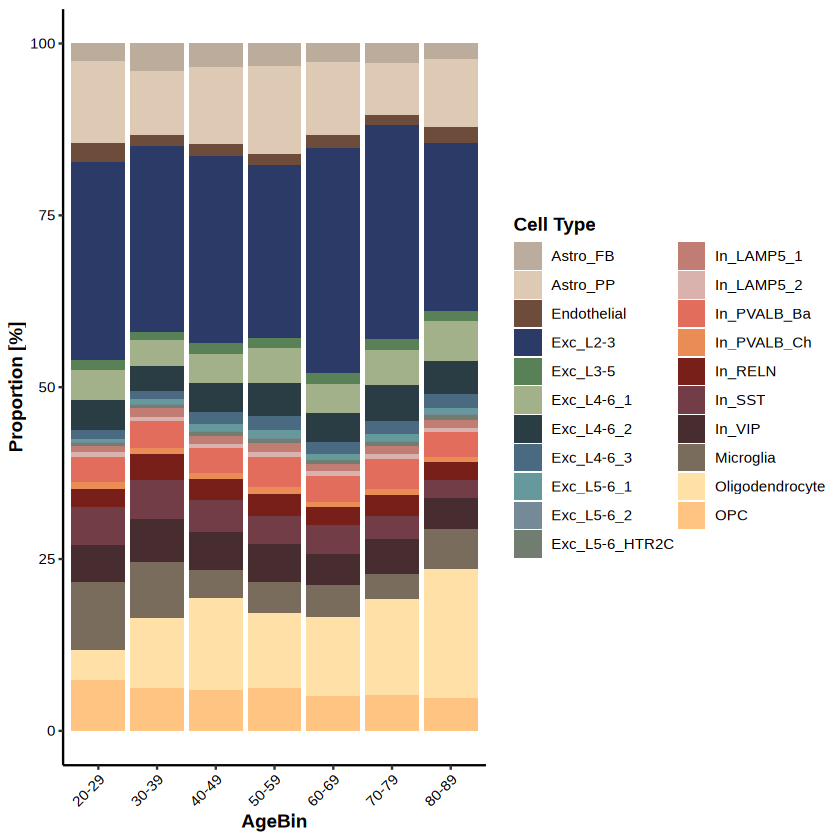

In [10]:
#stacked bar plot
ggplot(nuclei_prop_per_AgeBin, aes(fill=`Cell Type`, y=prop, x=AgeBin)) + 
  geom_bar(position="stack", stat="identity") + theme_classic() + theme(axis.text = element_text(color='black'))+
  scale_fill_manual(values=colors) + 
  xlab('AgeBin') + ylab('Proportion [%]') + theme(axis.title=element_text(face='bold'), legend.title = element_text(face='bold'), axis.text.x=element_text(angle=45, hjust=1))

ggsave('../figures/cellular_composition_stacked_bar_plot.pdf', plot = last_plot(), width = 6, height =4.5)

## Extended Data Fig. 4a

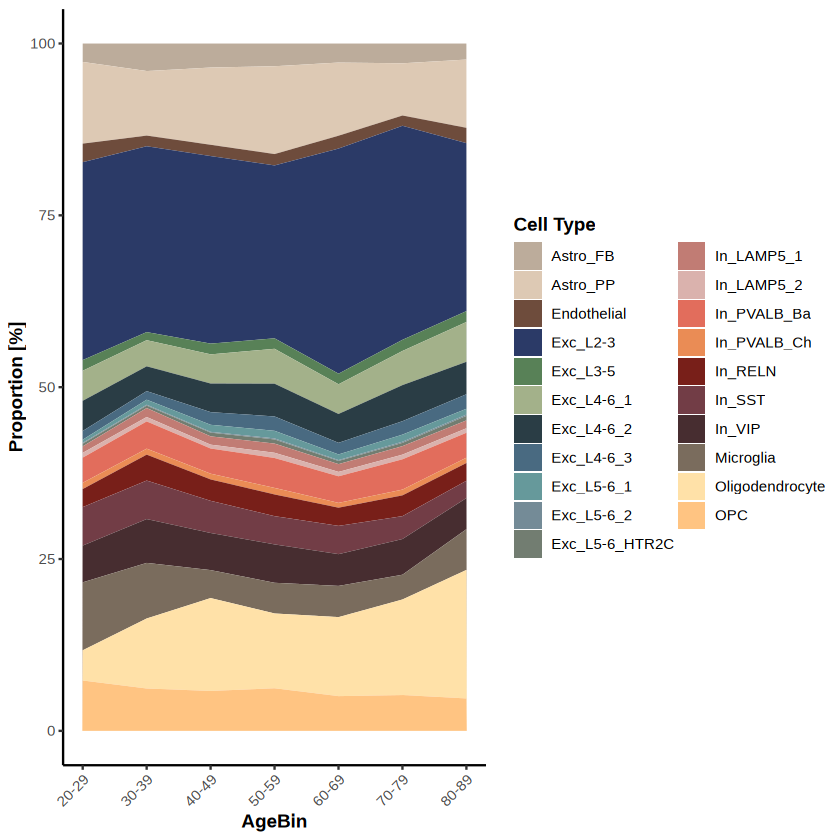

In [11]:
# Stacked area chart 
# x and y need to be continous - therefore format AgeBins to single value
nuclei_prop_per_AgeBin$Age <- nuclei_prop_per_AgeBin$AgeBin
nuclei_prop_per_AgeBin$Age <- as.character(nuclei_prop_per_AgeBin$Age)
nuclei_prop_per_AgeBin[nuclei_prop_per_AgeBin$AgeBin == '20-29',]$Age <- 20
nuclei_prop_per_AgeBin[nuclei_prop_per_AgeBin$AgeBin == '30-39',]$Age <- 30
nuclei_prop_per_AgeBin[nuclei_prop_per_AgeBin$AgeBin == '40-49',]$Age <- 40
nuclei_prop_per_AgeBin[nuclei_prop_per_AgeBin$AgeBin == '50-59',]$Age <- 50
nuclei_prop_per_AgeBin[nuclei_prop_per_AgeBin$AgeBin == '60-69',]$Age <- 60
nuclei_prop_per_AgeBin[nuclei_prop_per_AgeBin$AgeBin == '70-79',]$Age <- 70
nuclei_prop_per_AgeBin[nuclei_prop_per_AgeBin$AgeBin == '80-89',]$Age <- 80
nuclei_prop_per_AgeBin$Age <- as.numeric(nuclei_prop_per_AgeBin$Age)

ggplot(nuclei_prop_per_AgeBin, aes(fill=`Cell Type`, y=prop, x=Age)) + 
  geom_area() + theme_classic() + scale_fill_manual(values=colors) + 
  scale_x_continuous(breaks = c(20, 30, 40, 50, 60, 70, 80),
    label = c("20-29", "30-39", "40-49", '50-59', '60-69', '70-79', '80-89')
  ) + theme()  + xlab('AgeBin') + ylab('Proportion [%]') + 
  theme(axis.title=element_text(face='bold'), legend.title = element_text(face='bold'), axis.text.x=element_text(angle=45, hjust=1))

ggsave('../figures/cellular_composition_stacked_area_chart.pdf', plot = last_plot(), width = 6, height =4.5)

# SessionInfo

In [12]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /psycl/u/afroe/conda-envs/dreamlet_duplicated/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] writexl_1.4.2   readxl_1.4.3    lubridate_1.9.3 forcats_1.0.0  
 [5] stringr_1.5.0   dplyr_1.1.3     purrr_1.0.2     readr_2.1.4    
 [9] tidyr_1.3.0     tibble_3.2.1    ggplot2_3.4.4   tidyverse_2.0.0

loa